# Factors influencing the acceptance of applications

In the following we're going to take of look what factors are influence whether an application is certified or declined.


In [260]:
import cleanup
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.style.use('../own_style.mplstyle')

In [261]:
# cleanup.generate_cleaned_df()


In [262]:

col_list = ["case_status", "country_of_citizenship","employer_name" ,"employer_city", "foreign_worker_info_education", "pw_level_9089", "pw_soc_title", "prevailing_wage_amount_9089", "prevailing_wage_unit_of_pay_9089", "us_economic_sector", "class_of_admission"]
visas_df = pd.read_csv('../data/us_perm_visas_cleaned.csv', usecols=col_list)

C:\Users\andre\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (10,15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Firstly we're going to peek into the overall situation.

<AxesSubplot:title={'center':'Case Status Distribution'}, ylabel='Case Status'>

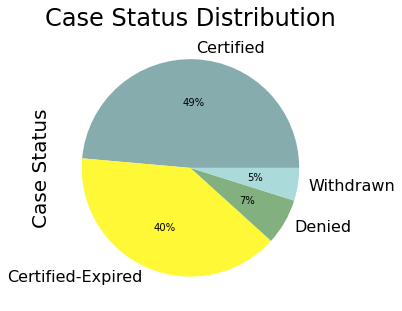

In [263]:
visas_df["case_status"].value_counts().plot(kind='pie', autopct='%1.0f%%', figsize=[15,5], ylabel = "Case Status", title = "Case Status Distribution")

To explain the possible values.

- Certified:
    - A “certified” status indicates the labor certification is granted. The certified application and a complete Final Determination form will be sent to the employer, or, if appropriate, to the employer’s agent or attorney, indicating the employer may file all the documents with the appropriate office in the Department of Homeland Security (DHS).
    - https://www.usavisanow.com/perm/perm-faq/perm-online-status-indicators/
    - PERM certified status means it has been approved and is valid for 180 days from the date of approval.
    - https://www.am22tech.com/uscis/perm-processing-time/
- Certified-Expired:
    - After the Labor Certification is approved by the DOL, an Immigrant Petition related to the Labor Certification should be filed with the U.S.C.I.S. before the expiration of the labor certification. The certification has a validity period of 180-days and expires if not submitted to USCIS within this period.
    - https://immsolutionsllc.com/work-visas/perm-labor-certification
    - PERM certified expired means that PERM was approved but was not used within 6 months to file i140 with USCIS.
    - https://www.am22tech.com/uscis/perm-processing-time/
- Denied:
    - A “denied” status indicates the application is denied. A Final Determination form, stating the reasons for the determination and advising the employer of how to request review, should the employer choose to do so, will be sent to the employer. The Final Determination must be included in any request for review, therefore, the employer must wait to receive the form before making such a request. The employer is also advised to wait for the Final Determination before filing a new application for the same alien to avoid repeating errors made in the original application.
    - https://www.usavisanow.com/perm/perm-faq/perm-online-status-indicators/
    - PERM application was denied by DOL.
    - https://www.am22tech.com/uscis/perm-processing-time/
- Withdrawn:
    - A “withdrawn” status indicates the employer has withdrawn the application.
    - https://www.usavisanow.com/perm/perm-faq/perm-online-status-indicators/
    - PERM application was withdrawn by employer.
    - https://www.am22tech.com/uscis/perm-processing-time/

Regarding the analysis question, factors influencing the acceptance of applications, some changes eill be made in the dataset.

"Certified-Expired" will be changed into "Certified"
And columns containing "Withdrawn" will be deleted.


<AxesSubplot:ylabel='case_status'>

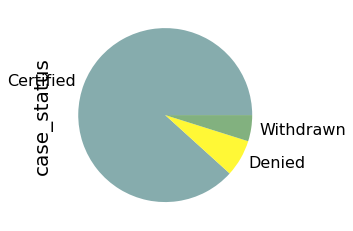

In [264]:
visas_df["case_status"] = visas_df["case_status"].str.replace('Certified-Expired', 'Certified')

visas_df["case_status"].value_counts().plot(kind='pie')

In [265]:
visas_df = visas_df[~visas_df["case_status"].str.contains("Withdrawn", na=False)]


<AxesSubplot:title={'center':'Case Status Distribution'}>

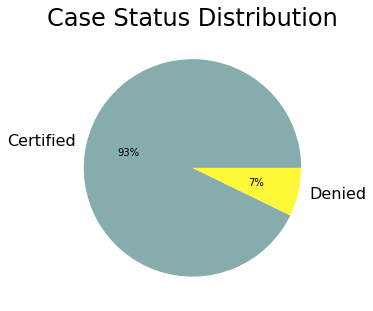

In [266]:
visas_df["case_status"].value_counts().plot(kind='pie', autopct='%1.0f%%', figsize=[15,5], ylabel = "", title = "Case Status Distribution")

Depict the pie chart as a stacked bar chart

<AxesSubplot:>

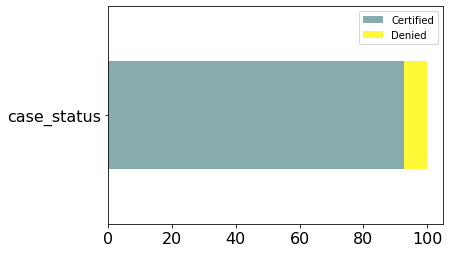

In [267]:
visas_df["case_status"].value_counts(normalize=True).mul(100).to_frame().T.plot.barh(stacked=True)

In [268]:
visas_df["case_status"].value_counts(normalize=True).mul(100)



Certified    92.798623
Denied        7.201377
Name: case_status, dtype: float64

In [269]:
median_certified_normalized = visas_df["case_status"].value_counts(normalize=True).mul(100).loc["Certified"]

## The Influence of the Country of Citizenship

Has the Country of Citizenship an influence wheather the application is certified or denied?

We will take a closer look a the 20 countries which were conntected by the most applications.

top20 is the dataframe containing all top20 countries and their count values

In [270]:
top20 = visas_df["country_of_citizenship"].value_counts().nlargest(20).reset_index()

top20.columns = ['country_of_citizenship', 'count']

top20 = top20.set_index(['country_of_citizenship'])

In [271]:
top20.head(20)

,count
country_of_citizenship,
INDIA,196585
CHINA,27454
SOUTH KOREA,22254
CANADA,14109
MEXICO,8564
PHILIPPINES,8182
UNITED KINGDOM,4714
TAIWAN,3944
PAKISTAN,3776


<AxesSubplot:xlabel='country_of_citizenship'>

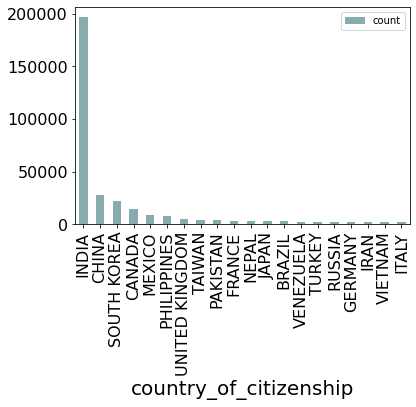

In [272]:
top20.plot.bar()

All entries which are not connected to one of the top20 countries will be dropped. The remaining columns will be assigned to df_top

In [273]:
df_top = visas_df.loc[visas_df['country_of_citizenship'].isin(top20.reset_index()['country_of_citizenship'])]

Next we will create a new DateFrame with normalized values for the case_status per country_of_citizenship

In [274]:
df_top_normalized_case_status = df_top["case_status"].groupby(df_top["country_of_citizenship"]).value_counts(normalize=True).mul(100).reset_index(name='counts')

In [275]:
df_top_normalized_case_status.head()

,country_of_citizenship,case_status,counts
0,BRAZIL,Certified,90.547798
1,BRAZIL,Denied,9.452202
2,CANADA,Certified,93.691970
3,CANADA,Denied,6.308030
4,CHINA,Certified,94.172070


Subsequently the generated table has to be pivoted in orer to be displayed in a stacked barchart. 
Help: https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html

In [276]:
df_top_normalized_case_status = df_top_normalized_case_status.pivot(index="country_of_citizenship", columns = "case_status", values = "counts")

In [277]:
df_top_normalized_case_status.head()

case_status,Certified,Denied
country_of_citizenship,,
BRAZIL,90.547798,9.452202
CANADA,93.691970,6.308030
CHINA,94.172070,5.827930
FRANCE,94.131223,5.868777
GERMANY,94.289509,5.710491


The stacked bar chart should be sorted by the cases each country of citizenship represents. In the moment the table is sorted alphabetical. The counted values have to be merged onto df_top_normalized_case_status.

In [278]:
df_top_normalized_case_status = df_top_normalized_case_status.merge(top20, left_on='country_of_citizenship', right_on='country_of_citizenship')
df_top_normalized_case_status = df_top_normalized_case_status.sort_values(by=['count'], ascending=False)

#df = df.drop(['index'], axis=1)
#df = df.drop(['count'], axis=1)
df_top_normalized_case_status.head()

,Certified,Denied,count
country_of_citizenship,,,
INDIA,95.158328,4.841672,196585
CHINA,94.172070,5.827930,27454
SOUTH KOREA,88.384111,11.615889,22254
CANADA,93.691970,6.308030,14109
MEXICO,76.389538,23.610462,8564


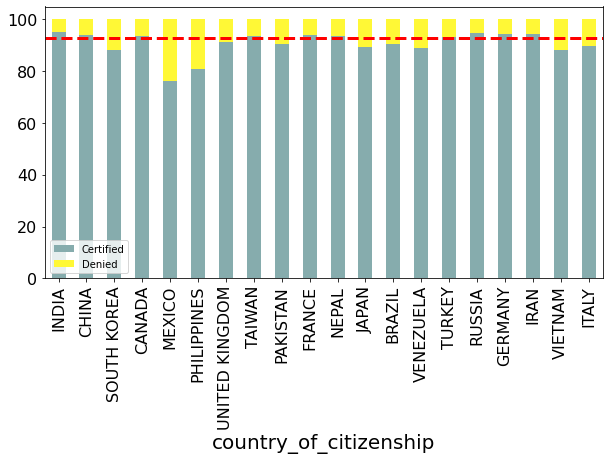

In [279]:
df_top_normalized_case_status[['Certified','Denied']].plot.bar(stacked=True, figsize=(10,5))

plt.axhline(median_certified_normalized, color='r', linestyle='--')

plt.show()

If the apllication is associated with a country_of_citizenship of Mexico or the philipines, the probability of acceptance is lower then the average.

In [280]:
## The Influence of the employer_name




In [281]:

def influence_on_acceptance_stacked_bar_chart(dataFrameToAnalyze = pd.DataFrame, invokesInfluence = str, isInfluencedBy = str, top = int, binnedData = False):

    #top columns of invokesInfluence
    topDf = dataFrameToAnalyze[invokesInfluence].value_counts().nlargest(top).reset_index()
    topDf.columns = [invokesInfluence, 'count']
    topDf = topDf.set_index([invokesInfluence])
    df_top = dataFrameToAnalyze.loc[dataFrameToAnalyze[invokesInfluence].isin(topDf.reset_index()[invokesInfluence])]


    df_top_normalized_case_status = df_top[isInfluencedBy].groupby(df_top[invokesInfluence]).value_counts(normalize=True).mul(100).reset_index(name='counts')

    df_top_normalized_case_status = df_top_normalized_case_status.pivot(index=invokesInfluence, columns = isInfluencedBy, values = "counts")

    df_top_normalized_case_status = df_top_normalized_case_status.merge(topDf, left_on=invokesInfluence, right_on=invokesInfluence)



    if binnedData == True:
        df_top_normalized_case_status = df_top_normalized_case_status.sort_values(by=[invokesInfluence], ascending=False)
    else:
        df_top_normalized_case_status = df_top_normalized_case_status.sort_values(by=['count'], ascending=False)


    df_top_normalized_case_status = df_top_normalized_case_status.fillna(0)
    #print(df_top_normalized_case_status.head())



    legend = list(df_top_normalized_case_status.loc[:, df_top_normalized_case_status.columns != 'count'].columns)

    #df_top_normalized_case_status[dataFrameToAnalyze[isInfluencedBy].unique()].plot.bar(stacked=True, figsize=(10,5))
    df_top_normalized_case_status[legend].plot.bar(stacked=True, figsize=(10,5))

    plt.axhline(median_certified_normalized, color='r', linestyle='--')

    plt.show()

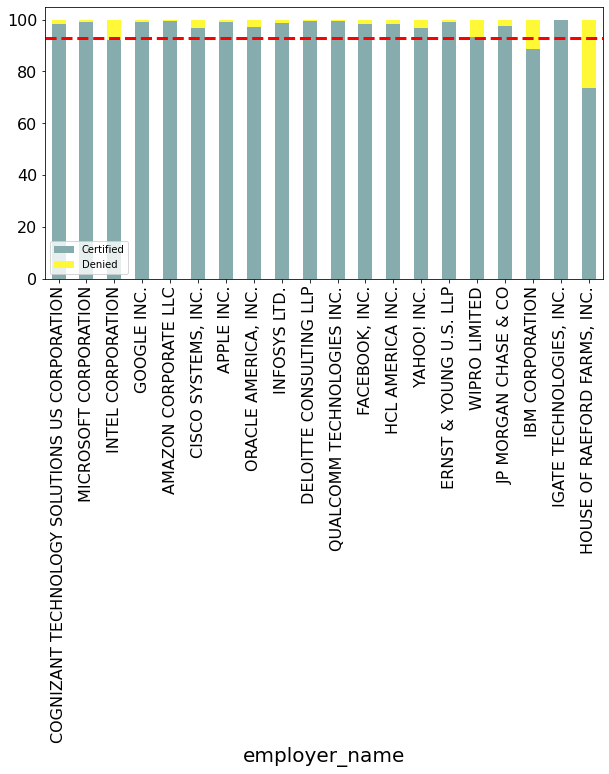

In [282]:
influence_on_acceptance_stacked_bar_chart(visas_df, "employer_name", "case_status", 20)

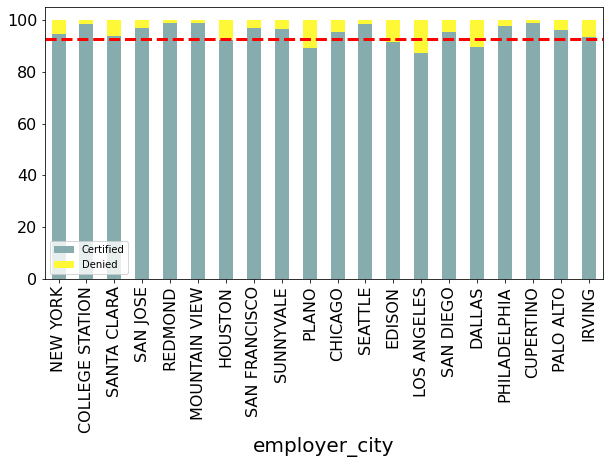

In [283]:
influence_on_acceptance_stacked_bar_chart(visas_df, "employer_city", "case_status", 20)

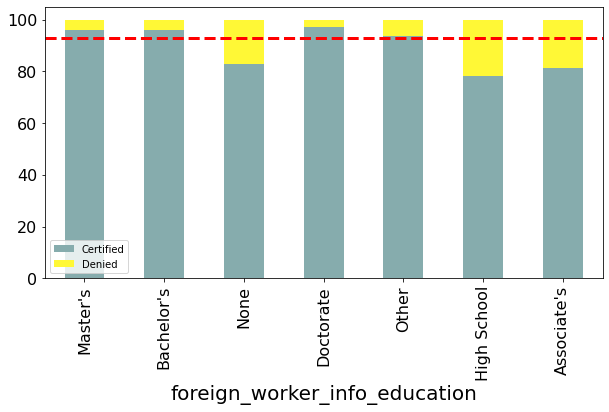

In [284]:
influence_on_acceptance_stacked_bar_chart(visas_df, "foreign_worker_info_education", "case_status", 20)

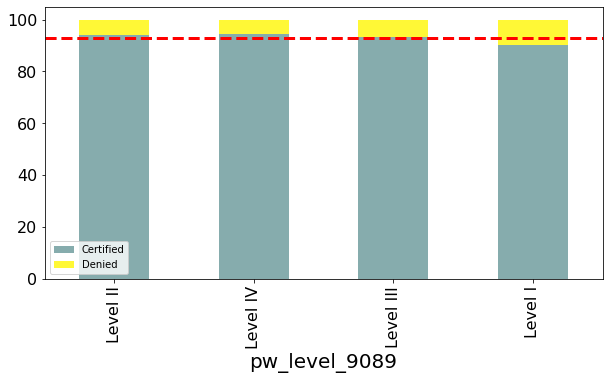

In [285]:
influence_on_acceptance_stacked_bar_chart(visas_df, "pw_level_9089", "case_status", 20)


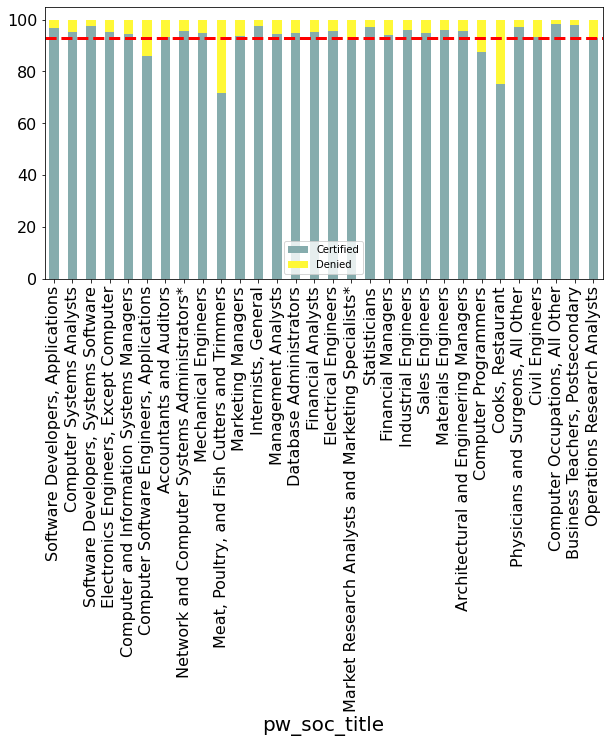

In [298]:
influence_on_acceptance_stacked_bar_chart(visas_df, "pw_soc_title", "case_status", 30)

## The Influence of the wage


In [287]:
wage_df = visas_df[visas_df["prevailing_wage_unit_of_pay_9089"].str.contains("yr", na=False)]

In [288]:
wage_df["prevailing_wage_amount_9089"] = wage_df["prevailing_wage_amount_9089"].fillna(0).astype(int)



<ipython-input-288-6293e6f196f5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wage_df["prevailing_wage_amount_9089"] = wage_df["prevailing_wage_amount_9089"].fillna(0).astype(int)


In [289]:

dsf = wage_df[wage_df['prevailing_wage_amount_9089'].between(0, 200000)]


In [290]:
dsf['prevailing_wage_amount_9089_bins'] = pd.qcut(dsf['prevailing_wage_amount_9089'], q=20)

<ipython-input-290-a09c45ef286c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dsf['prevailing_wage_amount_9089_bins'] = pd.qcut(dsf['prevailing_wage_amount_9089'], q=20)


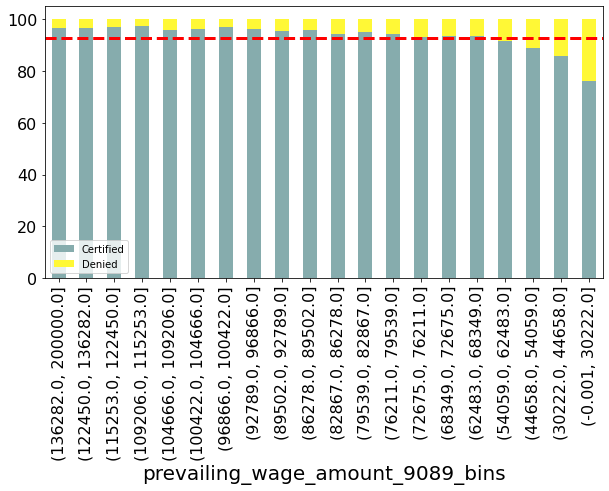

In [291]:

influence_on_acceptance_stacked_bar_chart(dsf, "prevailing_wage_amount_9089_bins", "case_status", 20, True)

The pw_wage has influnce on the acceptance of the application. Applications associated with low wage tend to get declined.


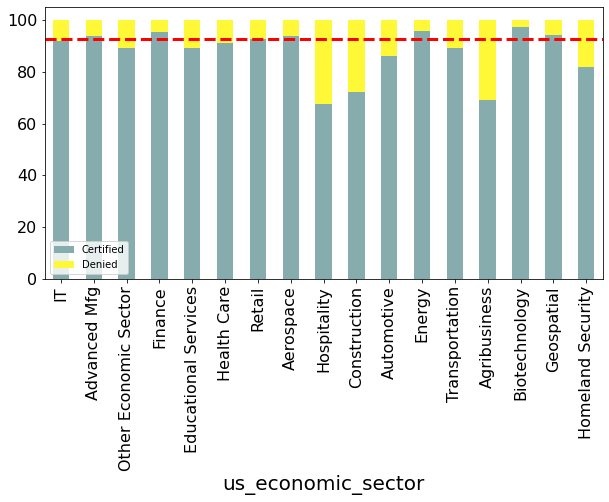

In [292]:

influence_on_acceptance_stacked_bar_chart(visas_df, "us_economic_sector", "case_status", 40)

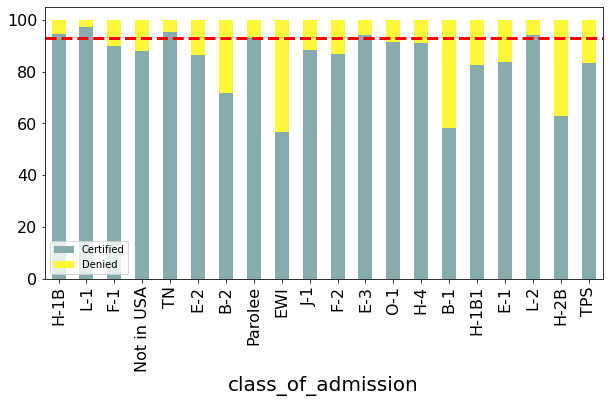

In [293]:

influence_on_acceptance_stacked_bar_chart(visas_df, "class_of_admission", "case_status", 20)

In [294]:
tempdf = visas_df[visas_df['class_of_admission'].notna()]

tempdf['class_of_admission'].value_counts()

H-1B          270467
L-1            19301
F-1            13994
Not in USA      7713
TN              4069
E-2             3941
B-2             3164
Parolee         2503
EWI             1878
J-1              905
F-2              879
E-3              837
O-1              761
H-4              693
B-1              591
H-1B1            519
E-1              513
L-2              503
H-2B             397
TPS              178
P-1              159
H-2A             151
A1/A2            149
G-4              102
R-1              102
J-2               95
I                 77
G-5               59
VWT               57
H-1A              40
C-1               38
P-3               36
H-3               36
A-3               28
M-1               25
O-2               19
TD                12
O-3               11
G-1               11
VWB               10
H-1C               7
C-3                6
P-4                6
D-1                6
Q                  5
Parol              5
R-2                5
T-1          

In [295]:
tempdf['class_of_admission'].isna().sum()

0

In [296]:
def influence_on_acceptance_stacked_bar_chart_1(dataFrameToAnalyze = pd.DataFrame, invokesInfluence = str, isInfluencedBy = str, CountOfTopValuesInvokesInfluence = int, CountOfTopValuesIsInfluencedBy = int, binnedData = False):

    #top columns of invokesInfluence
    topDf = dataFrameToAnalyze[invokesInfluence].value_counts().nlargest(CountOfTopValuesInvokesInfluence).reset_index()
    topDf.columns = [invokesInfluence, 'count']
    topDf = topDf.set_index([invokesInfluence])
    df_top = dataFrameToAnalyze.loc[dataFrameToAnalyze[invokesInfluence].isin(topDf.reset_index()[invokesInfluence])]

    #top columns of isInfluencedBy
    topDfInfluencedBy = dataFrameToAnalyze[isInfluencedBy].value_counts().nlargest(CountOfTopValuesIsInfluencedBy).reset_index()
    topDfInfluencedBy.columns = [isInfluencedBy, 'count']
    topDfInfluencedBy = topDfInfluencedBy.set_index([isInfluencedBy])
    df_top = df_top.loc[df_top[isInfluencedBy].isin(topDfInfluencedBy.reset_index()[isInfluencedBy])]




    df_top_normalized_case_status = df_top[isInfluencedBy].groupby(df_top[invokesInfluence]).value_counts(normalize=True).mul(100).reset_index(name='counts')

    df_top_normalized_case_status = df_top_normalized_case_status.pivot(index=invokesInfluence, columns = isInfluencedBy, values = "counts")

    df_top_normalized_case_status = df_top_normalized_case_status.merge(topDf, left_on=invokesInfluence, right_on=invokesInfluence)



    if binnedData == True:
        df_top_normalized_case_status = df_top_normalized_case_status.sort_values(by=[invokesInfluence], ascending=False)
    else:
        df_top_normalized_case_status = df_top_normalized_case_status.sort_values(by=['count'], ascending=False)


    df_top_normalized_case_status = df_top_normalized_case_status.fillna(0)


    legend = list(df_top_normalized_case_status.loc[:, df_top_normalized_case_status.columns != 'count'].columns)

    #print(df_top_normalized_case_status.head(20))

    #df_top_normalized_case_status[dataFrameToAnalyze[isInfluencedBy].unique()].plot.bar(stacked=True, figsize=(10,5))
    cmap = cm.get_cmap('twilight')
    df_top_normalized_case_status[legend].plot.bar(stacked=True, figsize=(10,5), colormap=cmap)

    plt.axhline(median_certified_normalized, color='r', linestyle='--')

    plt.show()

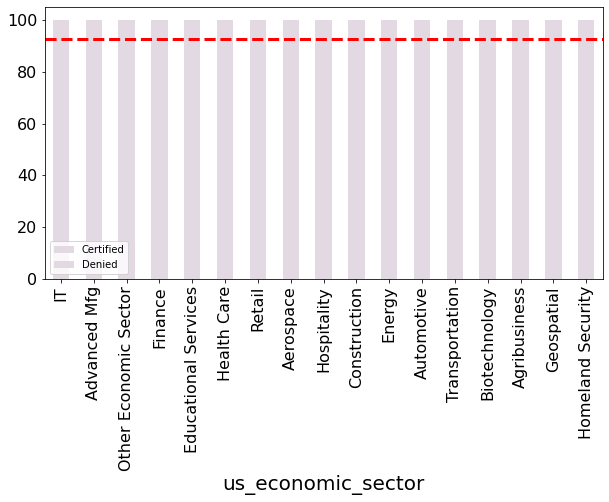

In [297]:

influence_on_acceptance_stacked_bar_chart_1(tempdf, "us_economic_sector", "case_status", 30, 6)